In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re
import string
import pandas as pd

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow_hub as hub
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("/kaggle/input/vqa-dataset/extracted_data.csv")
df['image_id'] = "/kaggle/input/vqa-dataset/" + df['image_id'].astype(str)+'.jpg'
df

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id,question
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",/kaggle/input/vqa-dataset/458752.jpg,other,458752000,What is this photo taken looking through?
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",/kaggle/input/vqa-dataset/458752.jpg,other,458752001,What position is this man playing?
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",/kaggle/input/vqa-dataset/458752.jpg,other,458752002,What color is the players shirt?
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,Is this man a professional baseball player?
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",/kaggle/input/vqa-dataset/262146.jpg,other,262146000,What color is the snow?
...,...,...,...,...,...,...,...
110934,how many,5,"[{'answer': '5', 'answer_confidence': 'yes', '...",/kaggle/input/vqa-dataset/555668.jpg,number,555668001,How many giraffes are in the picture?
110935,are the,indoors,"[{'answer': 'outdoors', 'answer_confidence': '...",/kaggle/input/vqa-dataset/555668.jpg,other,555668002,Are the giraffes indoors or outdoors?
110936,what is the,wood,"[{'answer': 'wood', 'answer_confidence': 'yes'...",/kaggle/input/vqa-dataset/31382.jpg,other,31382000,What is the table made of?
110937,none of the above,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",/kaggle/input/vqa-dataset/31382.jpg,yes/no,31382001,Did you they boil the corn?


In [5]:
image_path = list(df['image_id'])
question = list(df['question'])
answer = list(df['multiple_choice_answer'])

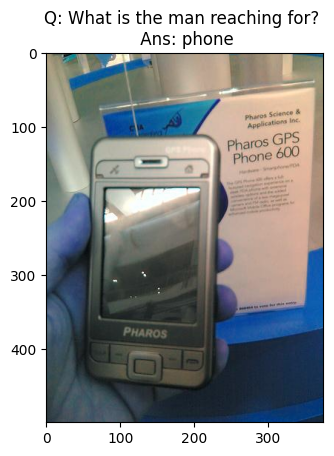

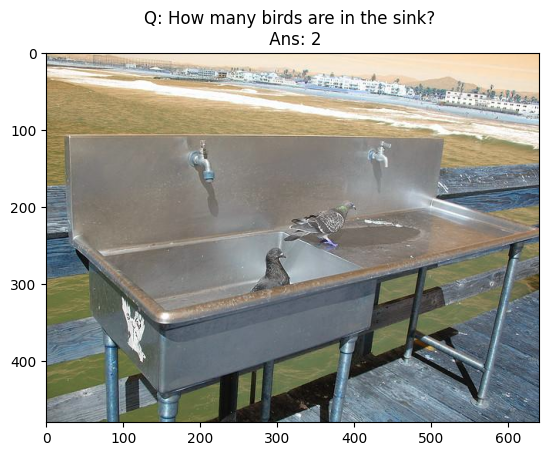

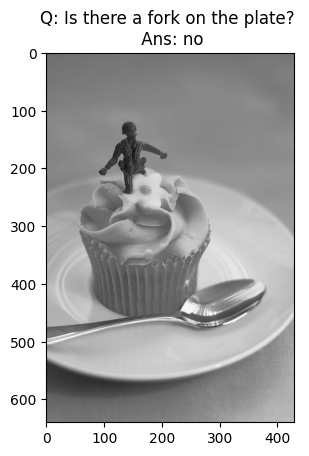

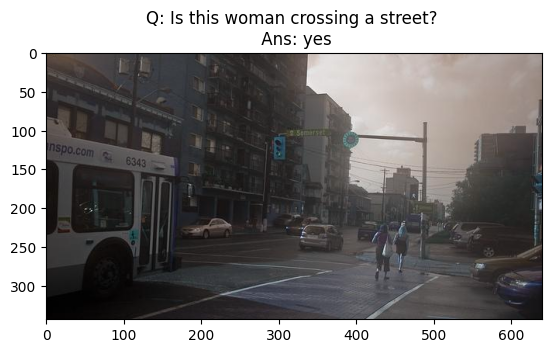

In [6]:
temp = random.sample(range(0, 1000), 4)
for a,i in enumerate(temp):
    image = cv2.imread(image_path[i])
    plt.figure()
    plt.title(f'Q: {question[i]} \n Ans: {answer[i]}')
    plt.imshow(image)

In [7]:
def find_punctuation(text):
    punctuation_list = []
    for t in text:
        for i in t:
            if i in string.punctuation:  
                punctuation_list.append(i)
    punctuation_list = list(set(punctuation_list))
    return punctuation_list

que_punct_list = find_punctuation(question)
ans_punct_list = find_punctuation(answer)
print(f'{len(que_punct_list)} punctuations found in the Question Dataset:\n{que_punct_list}')
print('-'*100)
print(f'{len(ans_punct_list)} punctuations found in the Answer Dataset:\n{ans_punct_list}')

19 punctuations found in the Question Dataset:
['#', '/', ':', '*', '_', ';', "'", '&', '"', '?', '+', '-', '$', '(', '!', ')', '%', ',', '.']
----------------------------------------------------------------------------------------------------
18 punctuations found in the Answer Dataset:
['@', '"', '?', '!', '/', '.', '_', ')', '+', '*', '%', "'", ',', ':', '-', '$', '(', '&']


In [8]:
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    
    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

In [9]:
# Question and Answer text preprocessing
df["question_preprocessed"] = df["question"].map(lambda x: text_preprocess(x))
df["answer_preprocessed"] = df["multiple_choice_answer"].map(lambda x: text_preprocess(x))


In [10]:
df

,question_type,multiple_choice_answer,answers,image_id,answer_type,question_id,question,question_preprocessed,answer_preprocessed
0,what is this,net,"[{'answer': 'net', 'answer_confidence': 'maybe...",/kaggle/input/vqa-dataset/458752.jpg,other,458752000,What is this photo taken looking through?,what is this photo taken looking through,net
1,what,pitcher,"[{'answer': 'pitcher', 'answer_confidence': 'y...",/kaggle/input/vqa-dataset/458752.jpg,other,458752001,What position is this man playing?,what position is this man playing,pitcher
2,what color is the,orange,"[{'answer': 'orange', 'answer_confidence': 'ye...",/kaggle/input/vqa-dataset/458752.jpg,other,458752002,What color is the players shirt?,what color is the players shirt,orange
3,is this,yes,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,Is this man a professional baseball player?,is this man a professional baseball player,yes
4,what color is the,white,"[{'answer': 'white', 'answer_confidence': 'yes...",/kaggle/input/vqa-dataset/262146.jpg,other,262146000,What color is the snow?,what color is the snow,white
...,...,...,...,...,...,...,...,...,...
110934,how many,5,"[{'answer': '5', 'answer_confidence': 'yes', '...",/kaggle/input/vqa-dataset/555668.jpg,number,555668001,How many giraffes are in the picture?,how many giraffes are in the picture,5
110935,are the,indoors,"[{'answer': 'outdoors', 'answer_confidence': '...",/kaggle/input/vqa-dataset/555668.jpg,other,555668002,Are the giraffes indoors or outdoors?,are the giraffes indoors or outdoors,indoors
110936,what is the,wood,"[{'answer': 'wood', 'answer_confidence': 'yes'...",/kaggle/input/vqa-dataset/31382.jpg,other,31382000,What is the table made of?,what is the table made of,wood
110937,none of the above,no,"[{'answer': 'no', 'answer_confidence': 'yes', ...",/kaggle/input/vqa-dataset/31382.jpg,yes/no,31382001,Did you they boil the corn?,did you they boil the corn,no


In [11]:
temp = random.sample(range(0, len(df)), 4)
for i in temp:
    print(f'Que: {df["question"][i]}\nAns: {df["multiple_choice_answer"][i]}')
print('-'*50)
for i in temp:
    print(f'Que: {df["question_preprocessed"][i]}\nAns: {df["answer_preprocessed"][i]}')

Que: What color is the truck?
Ans: blue
Que: What hue is this picture taken in?
Ans: red
Que: What kind of animal is this?
Ans: dog
Que: What color is the motorcycle?
Ans: green
--------------------------------------------------
Que: what color is the truck
Ans: blue
Que: what hue is this picture taken in
Ans: red
Que: what kind of animal is this
Ans: dog
Que: what color is the motorcycle
Ans: green


In [12]:
df = df.drop(['question', 'multiple_choice_answer'], axis=1)

cols = ['image_id','question_id','question_preprocessed','question_type','answer_preprocessed','answers','answer_type']


In [13]:
df

,question_type,answers,image_id,answer_type,question_id,question_preprocessed,answer_preprocessed
0,what is this,"[{'answer': 'net', 'answer_confidence': 'maybe...",/kaggle/input/vqa-dataset/458752.jpg,other,458752000,what is this photo taken looking through,net
1,what,"[{'answer': 'pitcher', 'answer_confidence': 'y...",/kaggle/input/vqa-dataset/458752.jpg,other,458752001,what position is this man playing,pitcher
2,what color is the,"[{'answer': 'orange', 'answer_confidence': 'ye...",/kaggle/input/vqa-dataset/458752.jpg,other,458752002,what color is the players shirt,orange
3,is this,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,is this man a professional baseball player,yes
4,what color is the,"[{'answer': 'white', 'answer_confidence': 'yes...",/kaggle/input/vqa-dataset/262146.jpg,other,262146000,what color is the snow,white
...,...,...,...,...,...,...,...
110934,how many,"[{'answer': '5', 'answer_confidence': 'yes', '...",/kaggle/input/vqa-dataset/555668.jpg,number,555668001,how many giraffes are in the picture,5
110935,are the,"[{'answer': 'outdoors', 'answer_confidence': '...",/kaggle/input/vqa-dataset/555668.jpg,other,555668002,are the giraffes indoors or outdoors,indoors
110936,what is the,"[{'answer': 'wood', 'answer_confidence': 'yes'...",/kaggle/input/vqa-dataset/31382.jpg,other,31382000,what is the table made of,wood
110937,none of the above,"[{'answer': 'no', 'answer_confidence': 'yes', ...",/kaggle/input/vqa-dataset/31382.jpg,yes/no,31382001,did you they boil the corn,no


In [14]:
image_path = list(df['image_id'])
question_preprocessed = list(df['question_preprocessed'])
answer_preprocessed = list(df['answer_preprocessed'])
question_type = list(df['question_type'])
answer_type = list(df['answer_type'])

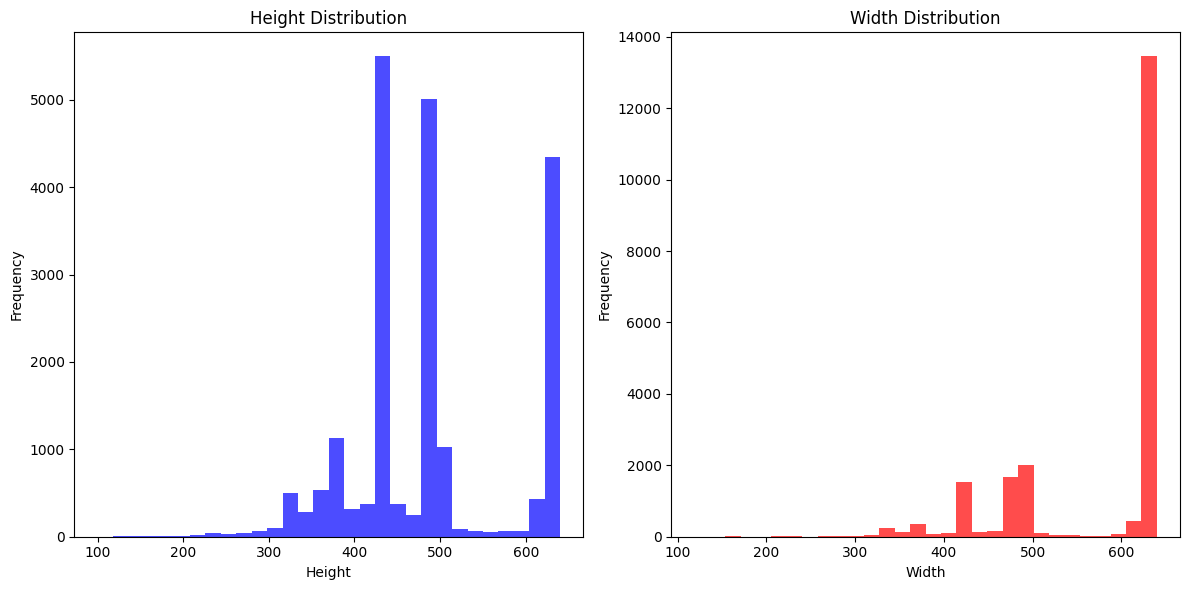

In [18]:
directory = "/kaggle/input/vqa-dataset"

# Lists to store heights and widths
heights = []
widths = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        # Read the image
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Get height and width
            h, w, _ = img.shape
            heights.append(h)
            widths.append(w)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(widths, bins=30, color='red', alpha=0.7)
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.savefig("dimension_distribution.png") 

plt.tight_layout()
plt.show()


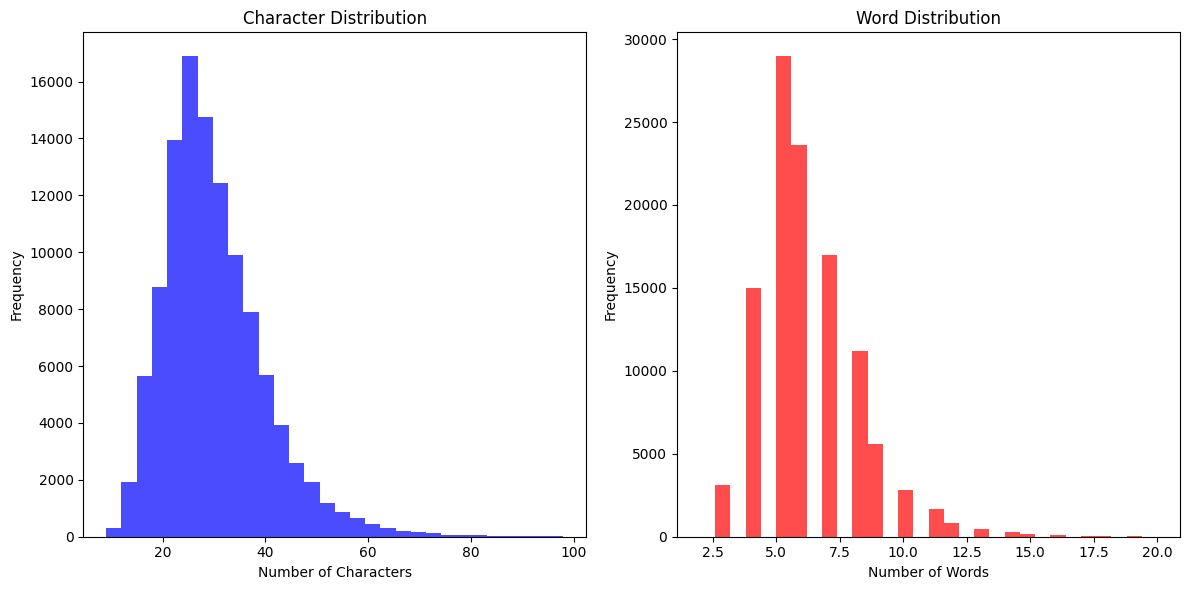

In [19]:

# Calculate number of characters and words
df['char_count'] = df['question_preprocessed'].apply(len)
df['word_count'] = df['question_preprocessed'].apply(lambda x: len(x.split()))

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['char_count'], bins=30, color='blue', alpha=0.7)
plt.title('Character Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['word_count'], bins=30, color='red', alpha=0.7)
plt.title('Word Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.savefig("char_word_distribution.png") 

plt.tight_layout()
plt.show()

In [20]:
label_encoder = LabelEncoder()

# Fit the label_encoder to your data and transform the 'answer_preprocessed' column
df['class_label'] = label_encoder.fit_transform(df['answer_preprocessed'])
df

,question_type,answers,image_id,answer_type,question_id,question_preprocessed,answer_preprocessed,char_count,word_count,class_label
0,what is this,"[{'answer': 'net', 'answer_confidence': 'maybe...",/kaggle/input/vqa-dataset/458752.jpg,other,458752000,what is this photo taken looking through,net,40,7,5344
1,what,"[{'answer': 'pitcher', 'answer_confidence': 'y...",/kaggle/input/vqa-dataset/458752.jpg,other,458752001,what position is this man playing,pitcher,33,6,6339
2,what color is the,"[{'answer': 'orange', 'answer_confidence': 'ye...",/kaggle/input/vqa-dataset/458752.jpg,other,458752002,what color is the players shirt,orange,31,6,5925
3,is this,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,is this man a professional baseball player,yes,42,7,9043
4,what color is the,"[{'answer': 'white', 'answer_confidence': 'yes...",/kaggle/input/vqa-dataset/262146.jpg,other,262146000,what color is the snow,white,22,5,8807
...,...,...,...,...,...,...,...,...,...,...
110934,how many,"[{'answer': '5', 'answer_confidence': 'yes', '...",/kaggle/input/vqa-dataset/555668.jpg,number,555668001,how many giraffes are in the picture,5,36,7,566
110935,are the,"[{'answer': 'outdoors', 'answer_confidence': '...",/kaggle/input/vqa-dataset/555668.jpg,other,555668002,are the giraffes indoors or outdoors,indoors,36,6,4251
110936,what is the,"[{'answer': 'wood', 'answer_confidence': 'yes'...",/kaggle/input/vqa-dataset/31382.jpg,other,31382000,what is the table made of,wood,25,6,8951
110937,none of the above,"[{'answer': 'no', 'answer_confidence': 'yes', ...",/kaggle/input/vqa-dataset/31382.jpg,yes/no,31382001,did you they boil the corn,no,26,6,5402


In [21]:
X = df[['image_id','question_preprocessed','answers']]
y = df['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)



X.shape: (110939, 3)
y.shape: (110939,)


In [22]:
df

,question_type,answers,image_id,answer_type,question_id,question_preprocessed,answer_preprocessed,char_count,word_count,class_label
0,what is this,"[{'answer': 'net', 'answer_confidence': 'maybe...",/kaggle/input/vqa-dataset/458752.jpg,other,458752000,what is this photo taken looking through,net,40,7,5344
1,what,"[{'answer': 'pitcher', 'answer_confidence': 'y...",/kaggle/input/vqa-dataset/458752.jpg,other,458752001,what position is this man playing,pitcher,33,6,6339
2,what color is the,"[{'answer': 'orange', 'answer_confidence': 'ye...",/kaggle/input/vqa-dataset/458752.jpg,other,458752002,what color is the players shirt,orange,31,6,5925
3,is this,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,is this man a professional baseball player,yes,42,7,9043
4,what color is the,"[{'answer': 'white', 'answer_confidence': 'yes...",/kaggle/input/vqa-dataset/262146.jpg,other,262146000,what color is the snow,white,22,5,8807
...,...,...,...,...,...,...,...,...,...,...
110934,how many,"[{'answer': '5', 'answer_confidence': 'yes', '...",/kaggle/input/vqa-dataset/555668.jpg,number,555668001,how many giraffes are in the picture,5,36,7,566
110935,are the,"[{'answer': 'outdoors', 'answer_confidence': '...",/kaggle/input/vqa-dataset/555668.jpg,other,555668002,are the giraffes indoors or outdoors,indoors,36,6,4251
110936,what is the,"[{'answer': 'wood', 'answer_confidence': 'yes'...",/kaggle/input/vqa-dataset/31382.jpg,other,31382000,what is the table made of,wood,25,6,8951
110937,none of the above,"[{'answer': 'no', 'answer_confidence': 'yes', ...",/kaggle/input/vqa-dataset/31382.jpg,yes/no,31382001,did you they boil the corn,no,26,6,5402


In [23]:
answer_preprocessed = list(df['answer_preprocessed'])
count = {}
for i in answer_preprocessed:
    count[i] = count.get(i, 0) + 1
    
answer_df = pd.DataFrame(list(count.items()),columns=["answer","answer_count"])
answer_df["answer%"] = answer_df["answer_count"]/len(answer_preprocessed)*100  
answer_df = answer_df.sort_values(by='answer_count',ascending=False)
answer_df.head(5)

,answer,answer_count,answer%
3,yes,21071,18.993321
11,no,20375,18.365949
15,1,3073,2.769991
20,2,2986,2.691569
4,white,2219,2.000198


In [24]:
top_1000_answers = list(answer_df['answer'])[:1000]

data_df = pd.DataFrame()
for i in (range(len(top_1000_answers))):
  data_df = pd.concat([data_df, df[df.answer_preprocessed == top_1000_answers[i]]])

print(f"Top 1000 answers coverd {round(len(data_df)/443757*100,2)}% of datapoints")

data_df['class_label'] = label_encoder.transform(list(data_df['answer_preprocessed']))
print("Number of Class Labels:",len(label_encoder.classes_))

print("Number of datapoints of final dataset:",len(data_df))
# data_df.to_csv("/content/drive/MyDrive/Applied AI/CS2/Data/mscoco_train2014_preprocessed_k1000.csv",index=False)
data_df.head(3)

Top 1000 answers coverd 21.94% of datapoints
Number of Class Labels: 9089
Number of datapoints of final dataset: 97373


,question_type,answers,image_id,answer_type,question_id,question_preprocessed,answer_preprocessed,char_count,word_count,class_label
3,is this,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,is this man a professional baseball player,yes,42,7,9043
8,is the,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/524291.jpg,yes/no,524291001,is the dog waiting,yes,18,4,9043
10,is the,"[{'answer': 'yes', 'answer_confidence': 'yes',...",/kaggle/input/vqa-dataset/393221.jpg,yes/no,393221000,is the sky blue,yes,15,4,9043


In [25]:
import ast

def extract_answers(answer_list):
    answers = ast.literal_eval(answer_list)
    return ','.join([entry['answer'] for entry in answers])

data_df['answers'] = data_df['answers'].apply(extract_answers)

data_df

,question_type,answers,image_id,answer_type,question_id,question_preprocessed,answer_preprocessed,char_count,word_count,class_label
3,is this,"yes,yes,yes,yes,yes,no,yes,yes,yes,yes",/kaggle/input/vqa-dataset/458752.jpg,yes/no,458752003,is this man a professional baseball player,yes,42,7,9043
8,is the,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",/kaggle/input/vqa-dataset/524291.jpg,yes/no,524291001,is the dog waiting,yes,18,4,9043
10,is the,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",/kaggle/input/vqa-dataset/393221.jpg,yes/no,393221000,is the sky blue,yes,15,4,9043
11,is there,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",/kaggle/input/vqa-dataset/393221.jpg,yes/no,393221001,is there snow on the mountains,yes,30,6,9043
13,is the,"yes,no,yes,no,yes,yes,yes,yes,yes,yes",/kaggle/input/vqa-dataset/393223.jpg,yes/no,393223000,is the window open,yes,18,4,9043
...,...,...,...,...,...,...,...,...,...,...
19937,what is,"pickle,pickles,knife,pickles,pickles,pickles,k...",/kaggle/input/vqa-dataset/398924.jpg,other,398924006,what is next to the sandwich on the plate,pickles,41,9,6278
28578,what is,"pickles,pickles,pickles,pickle,pickles,pickles...",/kaggle/input/vqa-dataset/139270.jpg,other,139270000,what is on top the sandwich,pickles,27,6,6278
65748,what are,"sprouts,pickles,lettuce,arugula,pickles,pickle...",/kaggle/input/vqa-dataset/280804.jpg,other,280804000,what are these green things,pickles,27,5,6278
102156,what are the,"pickles,pickles,pickles,pickles,pickles,pickle...",/kaggle/input/vqa-dataset/159924.jpg,other,159924003,what are the green things on the sausage,pickles,40,8,6278


In [26]:
columns_to_keep = ['image_id', 'question_preprocessed', 'answer_preprocessed', 'answers', 'class_label']

data_df = data_df[columns_to_keep]

data_df

,image_id,question_preprocessed,answer_preprocessed,answers,class_label
3,/kaggle/input/vqa-dataset/458752.jpg,is this man a professional baseball player,yes,"yes,yes,yes,yes,yes,no,yes,yes,yes,yes",9043
8,/kaggle/input/vqa-dataset/524291.jpg,is the dog waiting,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",9043
10,/kaggle/input/vqa-dataset/393221.jpg,is the sky blue,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",9043
11,/kaggle/input/vqa-dataset/393221.jpg,is there snow on the mountains,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",9043
13,/kaggle/input/vqa-dataset/393223.jpg,is the window open,yes,"yes,no,yes,no,yes,yes,yes,yes,yes,yes",9043
...,...,...,...,...,...
19937,/kaggle/input/vqa-dataset/398924.jpg,what is next to the sandwich on the plate,pickles,"pickle,pickles,knife,pickles,pickles,pickles,k...",6278
28578,/kaggle/input/vqa-dataset/139270.jpg,what is on top the sandwich,pickles,"pickles,pickles,pickles,pickle,pickles,pickles...",6278
65748,/kaggle/input/vqa-dataset/280804.jpg,what are these green things,pickles,"sprouts,pickles,lettuce,arugula,pickles,pickle...",6278
102156,/kaggle/input/vqa-dataset/159924.jpg,what are the green things on the sausage,pickles,"pickles,pickles,pickles,pickles,pickles,pickle...",6278


In [ ]:
X = data_df[['image_id','question_preprocessed','answers']]
y = data_df['class_label']
print('X.shape:',X.shape)
print('y.shape:',y.shape)

data_df.groupby(by='class_label').count()